In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import matplotlib.ticker as ticker
import numpy as np
import datetime

import os
path = os.getcwd()

In [2]:
# imports
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_selector
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union
from sklearn.compose import make_column_transformer
from sklearn import set_config
from sklearn.impute import SimpleImputer
#from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
#from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

In [3]:
df= pd.read_csv('data/df_for_regression.csv')
df.head()

,Unnamed: 0,Store ID,Item ID,Store Category,Store Segment,Store Region,City,Item Last Supplying Date,Supply Length,Region Language,Region Type,Cluster,Item_trailing_3_m_supply_date,Item Price,Declared Supply,Meals Saved,Total Supply,Pickup Length
0,0,35,34,Indie - Outbound,Bakery,Vaud,Salavaux,2022-03-01,999,french,urban,3,2021-12-01,6.9,3.14,3.05,3.29,20.0
1,1,57,73,Indie - Outbound,Bakery,Freiburg,Sâles,2022-03-01,997,french,urban,3,2021-12-01,6.9,1.94,2.09,2.26,30.0
2,2,58,74,Indie - Outbound,Bakery,Freiburg,Ursy,2022-02-26,976,french,urban,3,2021-11-28,4.9,0.00,1.33,1.37,30.0
3,3,58,337173,Indie - Outbound,Bakery,Freiburg,Ursy,2020-12-29,1,french,urban,3,2020-09-30,4.9,1.00,0.67,0.67,30.0
4,4,61,79,Indie - Outbound,Traditional Restaurant,Vaud,Lausanne,2022-02-26,960,french,urban,3,2021-11-28,6.9,1.00,0.97,1.00,30.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9735 entries, 0 to 9734
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     9735 non-null   int64  
 1   Store ID                       9735 non-null   int64  
 2   Item ID                        9735 non-null   int64  
 3   Store Category                 9735 non-null   object 
 4   Store Segment                  9735 non-null   object 
 5   Store Region                   9735 non-null   object 
 6   City                           9735 non-null   object 
 7   Item Last Supplying Date       9735 non-null   object 
 8   Supply Length                  9735 non-null   int64  
 9   Region Language                9735 non-null   object 
 10  Region Type                    9735 non-null   object 
 11  Cluster                        9735 non-null   int64  
 12  Item_trailing_3_m_supply_date  9735 non-null   o

## Data Preprocessing

In [5]:
# Check for duplicates
df.duplicated().sum()

0

In [6]:
# Check for nan:
df.isnull().sum().sort_values(ascending=False)

Unnamed: 0                       0
Store ID                         0
Total Supply                     0
Meals Saved                      0
Declared Supply                  0
Item Price                       0
Item_trailing_3_m_supply_date    0
Cluster                          0
Region Type                      0
Region Language                  0
Supply Length                    0
Item Last Supplying Date         0
City                             0
Store Region                     0
Store Segment                    0
Store Category                   0
Item ID                          0
Pickup Length                    0
dtype: int64

In [7]:
# Remove columns:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [8]:
df2 = df.drop(columns=['Meals Saved','Supply Length','Declared Supply','Store ID','Item ID','Item Last Supplying Date','City','Item_trailing_3_m_supply_date'])

In [9]:
#Removing outliers:
df=df[df['Total Supply']<=6]

In [10]:
df['Total Supply'].value_counts().sort_index()

0.02     4
0.03     1
0.04     1
0.05     3
0.06     2
        ..
5.92     2
5.93     1
5.96     1
5.98     1
6.00    30
Name: Total Supply, Length: 582, dtype: int64

In [11]:
df['Supply_binned']=pd.cut(x = df['Total Supply'],bins = [0,0.5,1.5,2.5,3.5,4.5,5.5,6], labels = [0, 1, 2,3,4,5,6])

In [12]:
df[['Total Supply', 'Supply_binned']]

,Total Supply,Supply_binned
0,3.29,3
1,2.26,2
2,1.37,1
3,0.67,1
4,1.00,1
...,...,...
9730,4.71,5
9731,5.00,5
9732,1.71,2
9733,2.00,2


In [13]:
df['Supply_binned'].value_counts()

1    3872
2    2549
3    1262
4     610
5     450
0     327
6     122
Name: Supply_binned, dtype: int64

In [14]:
df['Supply_binned'].value_counts()/len(df['Supply_binned'])

1    0.421236
2    0.277306
3    0.137293
4    0.066362
5    0.048956
0    0.035574
6    0.013272
Name: Supply_binned, dtype: float64

###### Grouping together 4,5,6

In [15]:
# label 4 groups values of Total Supply from 3.5 to 6:
df['Supply_binned']=pd.cut(x = df['Total Supply'],bins = [0,0.5,1.5,2.5,3.5,6], labels = [0, 1, 2,3,4])

In [16]:
df[['Total Supply', 'Supply_binned']]

,Total Supply,Supply_binned
0,3.29,3
1,2.26,2
2,1.37,1
3,0.67,1
4,1.00,1
...,...,...
9730,4.71,4
9731,5.00,4
9732,1.71,2
9733,2.00,2


In [17]:
df['Supply_binned'].value_counts()

1    3872
2    2549
3    1262
4    1182
0     327
Name: Supply_binned, dtype: int64

In [18]:
df['Supply_binned'].value_counts()/len(df['Supply_binned'])

1    0.421236
2    0.277306
3    0.137293
4    0.128590
0    0.035574
Name: Supply_binned, dtype: float64

## Visualization

<AxesSubplot:xlabel='Supply_binned', ylabel='count'>

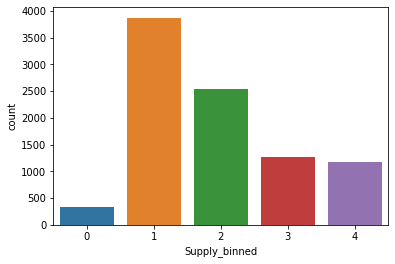

In [19]:
# Distribution of supply_binned
sns.countplot(x="Supply_binned", data=df)

In [20]:
df_plot=df.groupby(['Supply_binned','Cluster']).size().reset_index().pivot(columns='Cluster', index='Supply_binned', values=0)
df_plot

Cluster,0,1,2,3,4
Supply_binned,,,,,
0,239,4,0,68,16
1,2034,474,3,955,406
2,1464,153,1,575,356
3,634,62,2,329,235
4,526,113,6,211,326


<AxesSubplot:xlabel='Supply_binned'>

<Figure size 360x576 with 0 Axes>

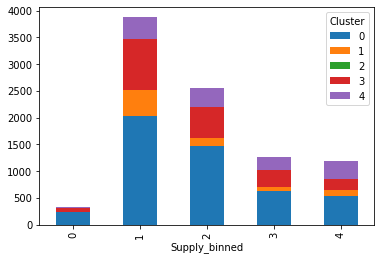

In [21]:
# Distribution of supply_binned by clusters
plt.figure(figsize=(5, 8))
df_plot.plot(kind='bar', stacked=True)

<AxesSubplot:xlabel='Supply_binned'>

<Figure size 360x576 with 0 Axes>

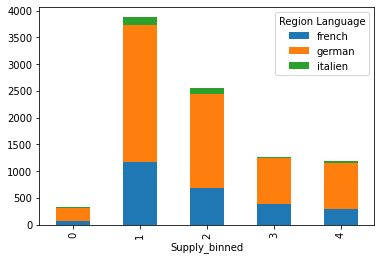

In [22]:
# Distribution of supply_binned by language
df_plot2=df.groupby(['Supply_binned','Region Language']).size().reset_index().pivot(columns='Region Language', index='Supply_binned', values=0)
df_plot2
plt.figure(figsize=(5, 8))
df_plot2.plot(kind='bar', stacked=True)

<AxesSubplot:xlabel='Supply_binned'>

<Figure size 360x576 with 0 Axes>

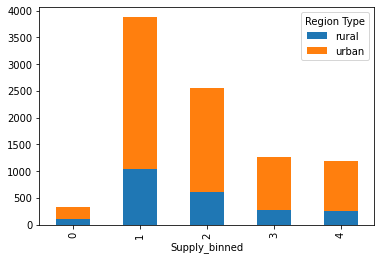

In [23]:
# Distribution of supply_binned by type
df_plot2=df.groupby(['Supply_binned','Region Type']).size().reset_index().pivot(columns='Region Type', index='Supply_binned', values=0)
df_plot2
plt.figure(figsize=(5, 8))
df_plot2.plot(kind='bar', stacked=True)

### Define X and y

In [24]:
# Remove columns: define X and y
X = df.drop(columns=['Meals Saved','Total Supply','Supply Length','Declared Supply','Supply_binned','Store ID','Item ID','Item Last Supplying Date','City','Item_trailing_3_m_supply_date'])
y = df['Supply_binned']

In [25]:
X.head()

,Store Category,Store Segment,Store Region,Region Language,Region Type,Cluster,Item Price,Pickup Length
0,Indie - Outbound,Bakery,Vaud,french,urban,3,6.9,20.0
1,Indie - Outbound,Bakery,Freiburg,french,urban,3,6.9,30.0
2,Indie - Outbound,Bakery,Freiburg,french,urban,3,4.9,30.0
3,Indie - Outbound,Bakery,Freiburg,french,urban,3,4.9,30.0
4,Indie - Outbound,Traditional Restaurant,Vaud,french,urban,3,6.9,30.0


In [26]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9192 entries, 0 to 9734
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Store Category   9192 non-null   object 
 1   Store Segment    9192 non-null   object 
 2   Store Region     9192 non-null   object 
 3   Region Language  9192 non-null   object 
 4   Region Type      9192 non-null   object 
 5   Cluster          9192 non-null   int64  
 6   Item Price       9192 non-null   float64
 7   Pickup Length    9192 non-null   float64
dtypes: float64(2), int64(1), object(5)
memory usage: 904.4+ KB


In [27]:
X.describe()

,Cluster,Item Price,Pickup Length
count,9192.000000,9192.000000,9192.000000
mean,1.370757,7.631485,88.581599
std,1.624279,5.230675,136.033419
min,0.000000,0.010000,0.000000
25%,0.000000,5.900000,30.000000
50%,0.000000,5.900000,30.000000
75%,3.000000,6.900000,60.000000
max,4.000000,94.900000,1185.000000


# Model 1: y=Total Supply

In [28]:
# Split into Train/Test -> to do on all dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [29]:
num_transformer = make_pipeline(RobustScaler())
cat_transformer = make_pipeline(OneHotEncoder(handle_unknown='ignore'))
preprocess = make_column_transformer((num_transformer, ['Item Price','Pickup Length']),
                                     (cat_transformer,['Store Category', 'Store Segment', 'Store Region', 'Region Language', 'Region Type','Cluster']))

In [30]:
# visualizing pipelines in HTML
set_config(display='diagram')
preprocess

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('robustscaler',
                                                  RobustScaler())]),
                                 ['Item Price', 'Pickup Length']),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Store Category', 'Store Segment',
                                  'Store Region', 'Region Language',
                                  'Region Type', 'Cluster'])])

In [31]:
X_train_transformed = preprocess.fit_transform(X_train)

In [32]:
display(pd.DataFrame(X_train_transformed.todense()).head(3))

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,2.0,0.853333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.220333,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [33]:
pd.DataFrame(X_train_transformed.todense(),columns=preprocess.get_feature_names_out())

,pipeline-1__Item Price,pipeline-1__Pickup Length,pipeline-2__Store Category_Indie - Inbound,pipeline-2__Store Category_Indie - Outbound,pipeline-2__Store Category_Key Account,pipeline-2__Store Category_Manufacturer,pipeline-2__Store Segment_Bakery,pipeline-2__Store Segment_Beverages,pipeline-2__Store Segment_Buffet,pipeline-2__Store Segment_Butcher,...,pipeline-2__Region Language_french,pipeline-2__Region Language_german,pipeline-2__Region Language_italien,pipeline-2__Region Type_rural,pipeline-2__Region Type_urban,pipeline-2__Cluster_0,pipeline-2__Cluster_1,pipeline-2__Cluster_2,pipeline-2__Cluster_3,pipeline-2__Cluster_4
0,2.0,0.853333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.220333,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.960667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.017667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6429,-1.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
6430,1.0,0.000000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
6431,2.0,1.666667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
6432,-1.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


### XGBoost

In [37]:
# Add Estimator
pipe = make_pipeline(preprocess, XGBClassifier(objective='multi:softmax',num_classes=5))
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('robustscaler',
                                                                   RobustScaler())]),
                                                  ['Item Price',
                                                   'Pickup Length']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Store Category',
                                                   'Store Segment',
                                                   'Store Region',
                                                   'Region Language',
                                                   'Region Type',
                                                   'Cluster'])])),
                ('xgbcl...
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_classes=5,
                               num_parallel_tree=None,
                               objective='multi:softmax', predictor=None,
                               random_state=None, reg_alpha=None,
                               reg_lambda=None, scale_pos_weight=None,
                               subsample=None, tree_method=None,
                               validate_parameters=None, verbosity=None))])

In [38]:
# Train pipeline, make predictions, score model
pipe.fit(X_train,y_train)
pipe.predict(X_test)
pipe.score(X_test,y_test)

/home/ttatiana/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:30:15] WARNING: ../src/learner.cc:576: 
Parameters: { "num_classes" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:30:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.4757070340826686

In [58]:
pipe.predict(X_test[0:2])
# Predict class labels

array([4, 2])

In [45]:
y_test[0:2]

2612    3
5867    2
Name: Supply_binned, dtype: category
Categories (5, int64): [0 < 1 < 2 < 3 < 4]

In [51]:
pipe[1].classes_

array([0, 1, 2, 3, 4])

In [52]:
#when multi_class='multinomial', coef_ corresponds to outcome 1 (True) and -coef_ corresponds to outcome 0 (False)
pipe[1].coef_

array([[-4.25078125e-02, -1.43721976e-02, -1.26135164e-01,
         2.27604532e-01,  3.65774740e-02, -1.95361577e-01,
        -1.06606113e+00, -9.92476583e-01, -3.33137556e-01,
        -1.15982126e+00,  7.39804331e-02, -8.95466606e-02,
         1.71508362e+00,  4.19587743e-01, -1.83233728e-01,
        -8.19533863e-01,  5.31205130e-01, -3.72759759e-01,
        -1.95361577e-01,  3.16425342e-01,  8.07751478e-01,
        -8.37940462e-01,  7.89936870e-01,  3.13283772e-01,
        -1.89521969e-01,  1.18851279e-04,  1.53272693e+00,
         4.19240215e-02, -3.59944380e-01, -4.71156754e-01,
         1.65524353e-01, -7.73752415e-01,  1.77708065e-01,
         6.73365551e-02, -5.22319285e-02, -1.97110924e-01,
        -5.98755646e-01, -1.53398354e-01,  4.31753514e-01,
         1.00455594e+00, -9.14859831e-02,  9.94631118e-02,
         6.27241219e-01,  9.13434281e-01, -2.89883317e-01,
        -3.86559750e-01, -8.70670519e-01, -1.04237465e-01,
        -4.71769524e-01,  1.68987849e-01,  3.34403126e-0

In [53]:
pipe[1].n_features_in_

65

In [57]:
pipe[1].get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'multinomial',
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [50]:
# Cross validate pipeline
cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy').mean()

0.2718381324913207

### Grid Search

In [ ]:
"""The choice of the algorithm depends on the penalty chosen: Supported penalties by solver:
‘newton-cg’ - [‘l2’, ‘none’]
‘lbfgs’ - [‘l2’, ‘none’]
‘sag’ - [‘l2’, ‘none’]
‘saga’ - [‘elasticnet’, ‘l1’, ‘l2’, ‘none’]
penalty default=’l2’

Solver: for multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss;
default=’lbfgs’
    
‘multinomial’ is unavailable when solver=’liblinear’"""

In [ ]:
# Train/Val
X_train_gs, X_val, y_train_gs, y_val = train_test_split(X_train_transformed, y_train, test_size=0.20, random_state=1)

# Instanciate model
estimator = LogisticRegression(multi_class='multinomial',n_jobs=-1,max_iter=1000)

# Hyperparameter Grid
param_grid={'penalty': ['l1','l2','none'],
            'C':[1,5,10],
            'class_weight': ['balanced', None],
            'solver':['saga']
           }

# Instanciate Grid Search
search = GridSearchCV(estimator, param_grid, 
                           scoring = ['accuracy',
                                      'balanced_accuracy'#to deal with imbalanced datasets: average of recall obtained on each class.
                                      #,'f1',
                                      #'recall',
                                      #'precision'
                                     ],
                           cv = 5,
                           n_jobs=-1, # paralellize computation
                      verbose=1,
                      refit=False
                          ) 

# Fit data to Grid Search
search.fit(X_train_gs,y_train_gs);
search.best_estimator_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [ ]:
# Best score
search.best_score_

In [ ]:
# Best Params
search.best_params_

In [ ]:
# Best estimator
search.best_estimator_

In [ ]:
model1 = LinearRegression()
parameters = {"fit_intercept": [True, False],
             }
search1 = GridSearchCV(estimator=model1, param_grid = parameters, scoring='r2', cv = 5, n_jobs=-1)
search1.fit(X_train_gs,y_train_gs)
search1.best_score_

In [ ]:
import joblib
joblib.dump(pipe5, 'linear_regression_supply.joblib')